In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification



In [3]:

# Verify GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [4]:
# Define the base path
base_path = "/content/drive/My Drive/preprocessed"
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

In [6]:
# Load model and processor
processor = AutoImageProcessor.from_pretrained("Organika/sdxl-detector")
model = AutoModelForImageClassification.from_pretrained("Organika/sdxl-detector")
model.to(device)

# Preprocess the images
def load_and_preprocess_image(file_path):
    image = Image.open(file_path).convert("RGB")
    return processor(image, return_tensors="pt").pixel_values

X = torch.cat([load_and_preprocess_image(fp) for fp in file_paths])
y = torch.tensor(labels)


preprocessor_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:

# Define the training loop
def train_model(model, train_loader, val_loader, num_epochs=5):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy: {100 * correct / total:.2f}%")

In [9]:
# Train the model
train_model(model, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Loss: 0.19535323723473333
Validation Accuracy: 97.00%
Epoch 2/5, Loss: 0.06723538066197017
Validation Accuracy: 96.07%
Epoch 3/5, Loss: 0.04351007779636844
Validation Accuracy: 95.38%
Epoch 4/5, Loss: 0.12343100931664759
Validation Accuracy: 95.38%
Epoch 5/5, Loss: 0.026259725753135916
Validation Accuracy: 96.07%


In [10]:
# Evaluate the model
model.eval()
y_val_pred = []
y_val_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        y_val_pred.extend(predicted.cpu().numpy())
        y_val_true.extend(labels.cpu().numpy())


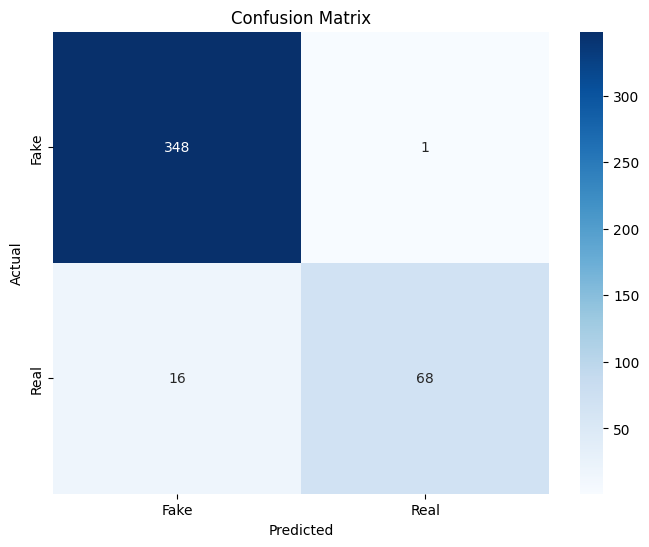

Precision: 0.9855072463768116
Recall: 0.8095238095238095
F1 Score: 0.8888888888888888


In [11]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred)
recall = recall_score(y_val_true, y_val_pred)
f1 = f1_score(y_val_true, y_val_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")